In [1]:
import numpy as np
import pandas as pd
import scipy
import psycopg2

import matplotlib.pyplot as plt

import os
import json
from collections import Counter

# Prototyping

In [2]:
def parse_testdata(path='../data/rainfall-submissions.tsv'):
    file = open(path,'r')
    raw = file.readlines()
    file.close()
    res = dict()
    exid = "3c79c115-0f5f-4d8e-b02c-b4b33155a4b3"
    get_code = lambda data: data["mooc-2017-ohjelmointi"]["osa02-Osa02_16.MarsinLampotilanKeskiarvo"]["/src/MarsinLampotilanKeskiarvo.java"]
    for line in raw:
        id = line[:len(exid)]
        body = json.loads(line[len(exid):])
        res[id] = get_code(body)
    return res

def parse_testdata_df(path='../data/rainfall-submissions.tsv'):
    file = open(path,'r')
    raw = file.readlines()
    file.close()
    ids = [None] * len(raw)
    code = [None] * len(raw)
    exid = "3c79c115-0f5f-4d8e-b02c-b4b33155a4b3"
    get_code = lambda data: data["mooc-2017-ohjelmointi"]["osa02-Osa02_16.MarsinLampotilanKeskiarvo"]["/src/MarsinLampotilanKeskiarvo.java"]
    for i, line in enumerate(raw):
        id = line[:len(exid)]
        body = json.loads(line[len(exid):])
        ids[i] = id
        code[i] = get_code(body)
    return pd.DataFrame({ "ids": ids, "code": code })

rain = parse_testdata()
rain_df = parse_testdata_df()

In [3]:
print(rain['b4df7baf-1ba2-4a67-8b82-dabc5a1a0bb8'])


import java.util.Scanner;

public class MarsinLampotilanKeskiarvo {

    public static void main(String[] args) {
        Scanner lukija = new Scanner(System.in);
        
        int summa = 0;
        int syotteet = 0;
        
        while (true) {
            System.out.print("Syötä luku: ");
            int syote = Integer.parseInt(lukija.nextLine());
            
            if (syote == 9999) {
                break;
            } else if (syote <= 20 && syote >= -140) {
                summa += syote;
                syotteet++;
            }
        }
        
        System.out.println("Mittausten keskiarvo: " 
                            + (double) summa / syotteet );
    }
}



In [14]:
import antlr4
from antlr_local.generated.JavaLexer import JavaLexer
from antlr_local.generated.JavaParser import JavaParser
from antlr_local.generated.JavaParserListener import JavaParserListener
from antlr_local.MyListener import KeyPrinter
from antlr_local.java_tokens import interestingTokenTypes, rareTokenTypes

import pprint

from antlr4 import RuleContext

from collections import Counter

code = rain['b4df7baf-1ba2-4a67-8b82-dabc5a1a0bb8']

code_stream = antlr4.InputStream(code)
lexer = JavaLexer(code_stream)
token_stream = antlr4.CommonTokenStream(lexer)
parser = JavaParser(token_stream)
tree = parser.compilationUnit()

printer = KeyPrinter()
walker = antlr4.ParseTreeWalker()
walker.walk(printer, tree)


In [22]:
c = Counter([interestingTokenTypes[t.type] for t in token_stream.getTokens(0, 188) if t.type in interestingTokenTypes])
c

Counter({'CLASS': 1,
         'VOID': 1,
         'ASSIGN': 4,
         'NEW': 1,
         'INT': 3,
         'DECIMAL_LITERAL': 5,
         'WHILE': 1,
         'BOOL_LITERAL': 1,
         'STRING_LITERAL': 2,
         'IF': 2,
         'EQUAL': 1,
         'BREAK': 1,
         'ELSE': 1,
         'LE': 1,
         'AND': 1,
         'GE': 1,
         'SUB': 1,
         'ADD_ASSIGN': 1,
         'INC': 1,
         'ADD': 1,
         'DOUBLE': 1,
         'DIV': 1})

In [23]:
print(printer.get_result())

IMPORT  
CLASS{  
VOID    
METHOD{ 
VARDEF 
ASSIGN  
NEWCLASS
VARDEF 
ASSIGN  
VARDEF 
ASSIGN  
LOOP{ 
APPLY   
VARDEF 
ASSIGN  
APPLY   
APPLY   
IF{     
ASSIGN  
BREAK   
IF{     
ASSIGN  
ASSIGN  
ASSIGN  
}IF     
}IF     
}LOOP 
APPLY   
}METHOD 
}CLASS  



In [27]:
s = []
def get_token_type_counts(data):
    count = Counter()
    for key in rain.keys():
        code = rain[key]
        code_stream = antlr4.InputStream(code)
        lexer = JavaLexer(code_stream)
        token_stream = antlr4.CommonTokenStream(lexer)
        parser = JavaParser(token_stream)
        tree = parser.compilationUnit()
        
        allTypes = [t.type for t in token_stream.tokens]
        
        count += Counter([interestingTokenTypes[t] for t in allTypes if t in interestingTokenTypes])

        r = Counter([rareTokenTypes[t] for t in allTypes if t in rareTokenTypes])

        if len(r.keys()) > 0:
            s.append((key, r))
    return count, s

typeCounts, s = get_token_type_counts(rain)

In [28]:
typeCounts

Counter({'CLASS': 110,
         'VOID': 110,
         'ASSIGN': 532,
         'NEW': 111,
         'INT': 323,
         'DECIMAL_LITERAL': 592,
         'WHILE': 110,
         'BOOL_LITERAL': 105,
         'STRING_LITERAL': 251,
         'IF': 219,
         'EQUAL': 105,
         'BREAK': 105,
         'ELSE': 59,
         'LE': 57,
         'AND': 52,
         'GE': 48,
         'SUB': 112,
         'ADD_ASSIGN': 106,
         'INC': 106,
         'ADD': 117,
         'DOUBLE': 105,
         'DIV': 110,
         'LT': 63,
         'OR': 58,
         'GT': 64,
         'CONTINUE': 66,
         'FLOAT_LITERAL': 57,
         'MUL': 53,
         'NOTEQUAL': 6,
         'FLOAT': 2,
         'BITAND': 1,
         'BOOLEAN': 1,
         'FOR': 1})

# Modeling

In [29]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import manifold
from sklearn.cluster import DBSCAN

import hdbscan
import umap

import antlr4
from antlr4 import RuleContext

from antlr_local.generated.JavaLexer import JavaLexer
from antlr_local.generated.JavaParser import JavaParser
from antlr_local.generated.JavaParserListener import JavaParserListener
from antlr_local.MyListener import KeyPrinter
from antlr_local.java_tokens import interestingTokenTypes, rareTokenTypes

import os
import json
import re
import glob
import pprint
from collections import Counter

def normalize_for_ai(source_code):
    res = re.sub("\/\*.*\*\/", "", source_code, flags=re.DOTALL) # multiline comment
    res = re.sub("\/\/.*", "", res) # inline comments
    res = re.sub("\".+\"", "\"\"", res) # string values
    res = re.sub("\d+", "$", res)
    return res

def counts_to_id_dict(ids, counts):
    d = {}
    for i, c in enumerate(counts):
        if None in c:
            c.pop(None)
        if len(c) != 0:
            d[ids[i]] = dict(c)
    return d

def parse_to_keyword_tokens(code):
    code_stream = antlr4.InputStream(code)
    lexer = JavaLexer(code_stream)
    token_stream = antlr4.CommonTokenStream(lexer)
    parser = JavaParser(token_stream)
    tree = parser.compilationUnit()

    allTypes = [t.type for t in token_stream.tokens]
    interestingTokens = [interestingTokenTypes[t] for t in allTypes if t in interestingTokenTypes]
    rareTokens = [rareTokenTypes[t] for t in allTypes if t in rareTokenTypes]
    return interestingTokens, rareTokens

def parse_ast_tokens(codeList):
    n = len(codeList)
    keywords = [None] * n
    rareKeywords = [None] * n
    keywordCounts = [None] * n
    rareKeywordCounts = [None] * n
    for i, c in enumerate(codeList):
        intTokens, rareTokens = parse_to_keyword_tokens(c)
        keywords[i] = intTokens
        rareKeywords[i] = rareTokens
        keywordCounts[i] = Counter(intTokens)
        rareKeywordCounts[i] = Counter(rareTokens)
    return keywords, rareKeywords, keywordCounts, rareKeywordCounts

def create_metrics(submissionIds, codeList):
    documents = len(codeList)
    keywords, rareKeywords, keywordCounts, rareKeywordCounts = parse_ast_tokens(codeList)
    return {
        "keywords": keywords,
        "rare_keywords": rareKeywords,
        "keyword_counts": counts_to_id_dict(submissionIds, keywordCounts),
        "rare_keyword_counts": counts_to_id_dict(submissionIds, rareKeywordCounts)
    }



In [30]:
m = create_metrics(rain_df.ids, rain_df.code)

In [31]:
m['keywords']

[['CLASS',
  'VOID',
  'ASSIGN',
  'NEW',
  'INT',
  'ASSIGN',
  'DECIMAL_LITERAL',
  'INT',
  'ASSIGN',
  'DECIMAL_LITERAL',
  'WHILE',
  'BOOL_LITERAL',
  'STRING_LITERAL',
  'INT',
  'ASSIGN',
  'IF',
  'EQUAL',
  'DECIMAL_LITERAL',
  'BREAK',
  'ELSE',
  'IF',
  'LE',
  'DECIMAL_LITERAL',
  'AND',
  'GE',
  'SUB',
  'DECIMAL_LITERAL',
  'ADD_ASSIGN',
  'INC',
  'STRING_LITERAL',
  'ADD',
  'DOUBLE',
  'DIV'],
 ['CLASS',
  'VOID',
  'ASSIGN',
  'NEW',
  'INT',
  'ASSIGN',
  'DECIMAL_LITERAL',
  'INT',
  'ASSIGN',
  'DECIMAL_LITERAL',
  'INT',
  'ASSIGN',
  'DECIMAL_LITERAL',
  'WHILE',
  'BOOL_LITERAL',
  'STRING_LITERAL',
  'ASSIGN',
  'IF',
  'EQUAL',
  'DECIMAL_LITERAL',
  'BREAK',
  'IF',
  'LT',
  'SUB',
  'DECIMAL_LITERAL',
  'OR',
  'GT',
  'DECIMAL_LITERAL',
  'CONTINUE',
  'ADD_ASSIGN',
  'INC',
  'STRING_LITERAL',
  'ADD',
  'FLOAT_LITERAL',
  'MUL',
  'DIV'],
 ['CLASS',
  'VOID',
  'ASSIGN',
  'NEW',
  'INT',
  'ASSIGN',
  'DECIMAL_LITERAL',
  'INT',
  'ASSIGN',
  'DECIMA

In [33]:
tlist, nlist, tokenCounts, rareTokenCounts = parse_ast_tokens(rain_df.code)

In [34]:
keywords = list(map(lambda x: ' '.join(x), tokenCounts))

In [35]:
df = pd.DataFrame({ "keywords": tokenCounts, "normalized": nlist })

ngrams = (2, 2)
n_components = 50

keyword_vectorizer = CountVectorizer(analyzer='word', 
                                   ngram_range=ngrams,
                                   token_pattern="[\S]+",
                                   lowercase=False,
                                   strip_accents="ascii")

transformer = TfidfTransformer(smooth_idf=False)

In [36]:
X = keyword_vectorizer.fit_transform(keywords)

tfidf = transformer.fit_transform(X)

res_tf = pd.DataFrame(X.A, columns=keyword_vectorizer.get_feature_names())

res_idf = pd.DataFrame(tfidf.A, columns=keyword_vectorizer.get_feature_names())

sim_matrix = np.around(cosine_similarity(tfidf), decimals=8)
dist_matrix = np.subtract(np.ones(sim_matrix.shape, dtype=np.int8), sim_matrix) # sim <=> 1 - dist

X_reduced = TruncatedSVD(n_components=n_components, random_state=0).fit_transform(tfidf)
#X_embedded = TSNE(n_components=2, perplexity=40, verbose=0).fit_transform(X_reduced)
X_embedded = umap.UMAP().fit_transform(X_reduced)

/Users/teemu/.virtualenvs/cc/lib/python3.7/site-packages/numba/np/ufunc/parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 11003. The TBB threading layer is disabled.
  warnings.warn(problem)


In [37]:
db = DBSCAN(min_samples=2, metric="precomputed", eps=0.05).fit(dist_matrix)
labels = db.labels_ # -1 = noise
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels) 

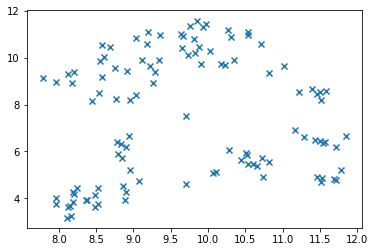

In [38]:
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker="x")

In [39]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=2, gen_min_span_tree=True)
clusterer.fit(dist_matrix)

/Users/teemu/.virtualenvs/cc/lib/python3.7/site-packages/hdbscan/hdbscan_.py:219: UserWarning: Cannot generate Minimum Spanning Tree; the implemented Prim's does not produce the full minimum spanning tree 
  'the full minimum spanning tree ', UserWarning)


HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
        approx_min_span_tree=True, cluster_selection_epsilon=0.0,
        cluster_selection_method='eom', core_dist_n_jobs=4,
        gen_min_span_tree=True, leaf_size=40,
        match_reference_implementation=False, memory=Memory(location=None),
        metric='euclidean', min_cluster_size=2, min_samples=None, p=None,
        prediction_data=False)

In [40]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

AttributeError: No minimum spanning tree was generated.This may be due to optimized algorithm variations that skip explicit generation of the spanning tree.

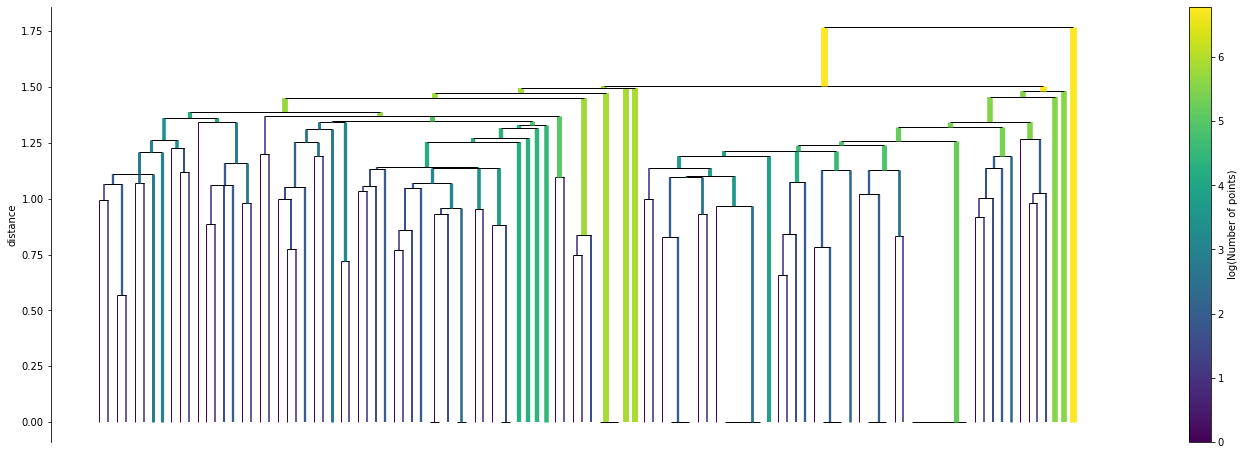

In [41]:
plt.figure(3,figsize=(24,8)) 
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

In [42]:
clusterer.labels_

array([17,  4, 21, 11, 12, 12, 24, 13,  4, 13,  3,  8, 17, 29,  1,  3,  4,
       25, -1, 14,  4, 28, 24, 19, -1,  0, 19, 25,  6,  4, 11,  3, 21,  7,
       -1,  7,  9, 19,  5, 29, 16, 20,  3,  5,  9, 28, -1,  1, 22, 27, 14,
        1, 10,  0, 15, 23, 25,  8, -1, -1, 11, 13, 18,  6, 16,  4, 28, 27,
       11,  2,  6, 13,  3, 20,  9, 26, 21, -1, 15, 24,  8,  1, 24, 21,  8,
       18,  4, -1, -1, -1,  9, 22, 21, 19,  2, 23,  2,  0, -1, 27, -1, 26,
       22, -1, 27, -1,  8, 10, 21, 22])

In [43]:
tokenCounts

[Counter({'CLASS': 1,
          'VOID': 1,
          'ASSIGN': 4,
          'NEW': 1,
          'INT': 3,
          'DECIMAL_LITERAL': 5,
          'WHILE': 1,
          'BOOL_LITERAL': 1,
          'STRING_LITERAL': 2,
          'IF': 2,
          'EQUAL': 1,
          'BREAK': 1,
          'ELSE': 1,
          'LE': 1,
          'AND': 1,
          'GE': 1,
          'SUB': 1,
          'ADD_ASSIGN': 1,
          'INC': 1,
          'ADD': 1,
          'DOUBLE': 1,
          'DIV': 1}),
 Counter({'CLASS': 1,
          'VOID': 1,
          'ASSIGN': 5,
          'NEW': 1,
          'INT': 3,
          'DECIMAL_LITERAL': 6,
          'WHILE': 1,
          'BOOL_LITERAL': 1,
          'STRING_LITERAL': 2,
          'IF': 2,
          'EQUAL': 1,
          'BREAK': 1,
          'LT': 1,
          'SUB': 1,
          'OR': 1,
          'GT': 1,
          'CONTINUE': 1,
          'ADD_ASSIGN': 1,
          'INC': 1,
          'ADD': 1,
          'FLOAT_LITERAL': 1,
          'MUL': 1,
    

In [44]:
print(rain['52c74ea5-e618-4556-86e5-1de449155818'])


import java.util.Scanner;

public class MarsinLampotilanKeskiarvo {

    public static void main(String[] args) {
        Scanner lukija = new Scanner(System.in);
        
        int luku = 0;
        int keskiarvo = 0;
        int jaettava = 0;
        
        while(luku != 9999){
            System.out.println("Syötä mittaus: ");
            luku = Integer.parseInt(lukija.nextLine());
            
            if(luku >= -140 & luku <= 20){
                keskiarvo = keskiarvo + luku;
                jaettava++;
            }
        }
        double tulos = ((double)keskiarvo/jaettava);
        System.out.println("Kelvollisia lukuja yhteensä " + tulos);
        
        
        
    }
}



In [45]:
print(rain['2f1f4d66-5ba8-4db6-8ce3-684709e43372'])


import java.util.Scanner;

public class MarsinLampotilanKeskiarvo {

    public static void main(String[] args) {
        Scanner lukija = new Scanner(System.in);
        int summa = 0, lkm = 0, syotto;
        while(true) {
            System.out.print("Syötä luku: ");
            syotto = Integer.parseInt(lukija.nextLine());
            if(syotto == 9999) {
                break;
            } else if(syotto >= -140 && syotto <= 20) {
                summa += syotto;
                lkm++;
                continue;
            }
            System.out.println("\nKelvoton luku");
        }
        System.out.println("Mittausten keskiarvo: " + ((double)summa / lkm));
    }
}



In [46]:
print(rain['a30ca9ce-eb03-4b16-aa0d-5d8c2e4748f6'])


import java.util.Scanner;

public class MarsinLampotilanKeskiarvo {

    public static void main(String[] args) {
        Scanner lukija = new Scanner(System.in);
        int luku = 0;
        int lukuja = 0;
        int summa = 0;

        while (true) {
            System.out.print("Syötä mittaus: ");
            luku = Integer.parseInt(lukija.nextLine());
            if (luku == 9999) {
                break;
            }
            if (!(luku < -140 || luku > 20)) {
                lukuja += 1;
                summa += luku;
            }
        }

        System.out.println("Mittausten keskiarvo: " + (double) summa / (double) lukuja);
    }
}



In [47]:
typeCounts

Counter({'CLASS': 110,
         'VOID': 110,
         'ASSIGN': 532,
         'NEW': 111,
         'INT': 323,
         'DECIMAL_LITERAL': 592,
         'WHILE': 110,
         'BOOL_LITERAL': 105,
         'STRING_LITERAL': 251,
         'IF': 219,
         'EQUAL': 105,
         'BREAK': 105,
         'ELSE': 59,
         'LE': 57,
         'AND': 52,
         'GE': 48,
         'SUB': 112,
         'ADD_ASSIGN': 106,
         'INC': 106,
         'ADD': 117,
         'DOUBLE': 105,
         'DIV': 110,
         'LT': 63,
         'OR': 58,
         'GT': 64,
         'CONTINUE': 66,
         'FLOAT_LITERAL': 57,
         'MUL': 53,
         'NOTEQUAL': 6,
         'FLOAT': 2,
         'BITAND': 1,
         'BOOLEAN': 1,
         'FOR': 1})

# Weird stuff below, probably not working

In [48]:
from antlr4.tree.Trees import Trees
# import your parser & lexer here

# setup your lexer, stream, parser and tree like normal

print(Trees.toStringTree(tree, None, parser))

(compilationUnit (importDeclaration import (qualifiedName java . util . Scanner) ;) (typeDeclaration (classOrInterfaceModifier public) (classDeclaration class MarsinLampotilanKeskiarvo (classBody { (classBodyDeclaration (modifier (classOrInterfaceModifier public)) (modifier (classOrInterfaceModifier static)) (memberDeclaration (methodDeclaration (typeTypeOrVoid void) main (formalParameters ( (formalParameterList (formalParameter (typeType (classOrInterfaceType String) [ ]) (variableDeclaratorId args))) )) (methodBody (block { (blockStatement (localVariableDeclaration (typeType (classOrInterfaceType Scanner)) (variableDeclarators (variableDeclarator (variableDeclaratorId lukija) = (variableInitializer (expression new (creator (createdName Scanner) (classCreatorRest (arguments ( (expressionList (expression (expression (primary System)) . in)) ))))))))) ;) (blockStatement (localVariableDeclaration (typeType (primitiveType int)) (variableDeclarators (variableDeclarator (variableDeclaratorI

In [49]:
tree.toStringTree()

'([] ([211] import ([239 211] java . util . Scanner) ;) ([217] ([246 217] public) ([252 217] class MarsinLampotilanKeskiarvo ([295 252 217] { ([385 295 252 217] ([407 385 295 252 217] ([261 407 385 295 252 217] public)) ([407 385 295 252 217] ([261 407 385 295 252 217] static)) ([413 385 295 252 217] ([416 413 385 295 252 217] ([427 416 413 385 295 252 217] void) main ([429 416 413 385 295 252 217] ( ([626 429 416 413 385 295 252 217] ([631 626 429 416 413 385 295 252 217] ([652 631 626 429 416 413 385 295 252 217] ([1337 652 631 626 429 416 413 385 295 252 217] String) [ ]) ([653 631 626 429 416 413 385 295 252 217] args))) )) ([441 416 413 385 295 252 217] ([443 441 416 413 385 295 252 217] { ([790 443 441 416 413 385 295 252 217] ([798 790 443 441 416 413 385 295 252 217] ([811 798 790 443 441 416 413 385 295 252 217] ([1337 811 798 790 443 441 416 413 385 295 252 217] Scanner)) ([812 798 790 443 441 416 413 385 295 252 217] ([554 812 798 790 443 441 416 413 385 295 252 217] ([562 5

In [126]:
import antlr4
from antlr_local.JavaLexer import JavaLexer
from antlr_local.JavaParser import JavaParser
from antlr_local.JavaParserListener import JavaParserListener
from MyListener import KeyPrinter
import pprint

from antlr4 import RuleContext

from collections import Counter

def parse_to_compositional_tokens(code):
    #print("parsing: ", self.ID)
    code_stream = antlr4.InputStream(code)
    lexer = JavaLexer(code_stream)
    token_stream = antlr4.CommonTokenStream(lexer)
    parser = JavaParser(token_stream)
    tree = parser.compilationUnit()

    printer = KeyPrinter()
    walker = antlr4.ParseTreeWalker()
    walker.walk(printer, tree)

    return printer.get_result()

def parse_to_tokens(code):
    #print("parsing: ", self.ID)
    code_stream = antlr4.InputStream(code)
    lexer = JavaLexer(code_stream)
    token_stream = antlr4.CommonTokenStream(lexer)
    parser = JavaParser(token_stream)
    tree = parser.compilationUnit()

    token_count = token_stream.getNumberOfOnChannelTokens()
    tokens = [t for t in token_stream.getTokens(0, token_count)]
    return [t.type for t in tokens]
    #printer = KeyPrinter()
    #walker = antlr4.ParseTreeWalker()
    #walker.walk(printer, tree)

    #return printer.get_result()

def parse_compositionals(codeDict):
    ids = list(codeDict.keys())
    counts = [None] * len(ids)
    total = Counter()
    freqs = Counter()
    for i in range(0, len(ids)):
        c = codeDict[ids[i]]
        tokens = parse_to_compositional_tokens(c)
        counts[i] = cnt
        total += cnt
        freqs += Counter(set(cnt))
    return counts, total, freqs

def parse_code_to_counts(codeDict):
    ids = list(codeDict.keys())
    counts = [None] * len(ids)
    total = Counter()
    freqs = Counter()
    for i in range(0, len(ids)):
        cnt = Counter(parse_to_tokens(codeDict[ids[i]]))
        counts[i] = cnt
        total += cnt
        freqs += Counter(set(cnt))
    return counts, total, freqs

def comp_tf_idf(counts, total, freqs):
    keys = list(total.keys())
    docs = len(counts)
    res = [None] * docs #np.zeros(docs)
    alldict = dict()
    for i in range(0, len(counts)):
        c = counts[i]
        terms = sum(c)
        term_list = list(c.keys())
        d = dict()
        for ii in range(0, len(term_list)):
            t = term_list[ii]
            tf = np.log(c[t] / terms)
            d[t] = (tf, freqs[t], (freqs[t]/docs)**4)
            if t in alldict:
                alldict[t].append(tf)
            else:
                alldict[t] = [tf]
        res[i] = d
    return res, alldict

#tt = parse_to_tokens(rain['b4df7baf-1ba2-4a67-8b82-dabc5a1a0bb8'])

counts, total, freqs = parse_code_to_counts(rain)

In [127]:
tflist, tfdict = comp_tf_idf(counts, total, freqs)

In [137]:
np.log(111/88)

0.23219338683412774

In [135]:
np.log(88/111)

-0.23219338683412766

In [128]:
tfdict

{108: [-3.4861062789868646,
  -3.462008727407804,
  -3.912023005428146,
  -3.473148835188852,
  -3.5373295559867355,
  -3.43847822999761,
  -3.6971782569286313,
  -3.46107078270957,
  -3.462008727407804,
  -3.393015855920853,
  -3.4657359027997265,
  -3.4034171384004686,
  -3.462008727407804,
  -3.6808931024812863,
  -3.4724100098874198,
  -3.6832385742238505,
  -3.4861062789868646,
  -3.472813073173812,
  -3.6882840387941727,
  -3.415264638873591,
  -3.4861062789868646,
  -3.4861062789868646,
  -3.714822066867068,
  -3.4392247772513946,
  -3.462008727407804,
  -3.6270040503958487,
  -3.311474401229129,
  -3.4130318393091583,
  -3.4410006756650047,
  -3.462008727407804,
  -3.462008727407804,
  -3.393015855920853,
  -3.4861062789868646,
  -3.3329806064500924,
  -3.4972463867679124,
  -3.3260040080500564,
  -3.4861062789868646,
  -3.3535523948600803,
  -3.443263046947668,
  -3.460862938057852,
  -3.4965075614664802,
  -3.531693870591524,
  -3.3710369492020775,
  -3.43847822999761,
  -3.4

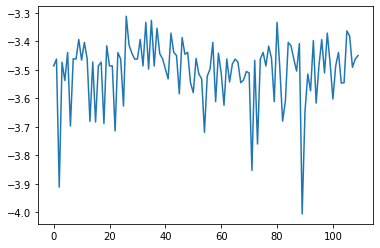

In [129]:
plt.plot(tfdict[108])

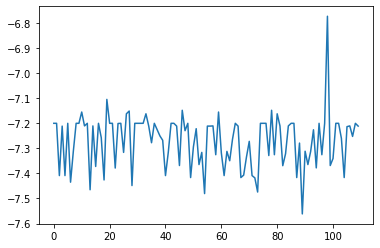

In [130]:
plt.plot(tfdict[25])

In [124]:
np.log(0.0007008792935008493)

-7.263174877623953

In [125]:
np.log(0.001145475372279496)

-6.771935555839602

In [123]:
print(np.mean(tfdict[25]))
print(np.std(tfdict[25]))
print(np.max(tfdict[25]))
print(np.min(tfdict[25]))


0.0007008792935008493
7.656234797461671e-05
0.001145475372279496
0.0005200208008320333


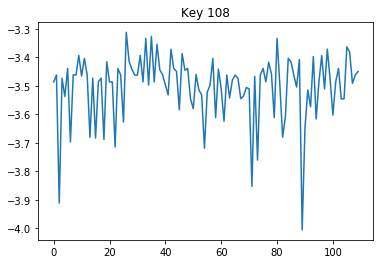

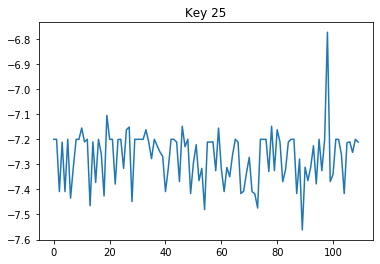

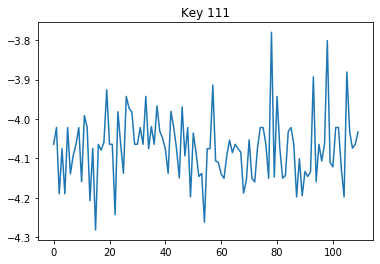

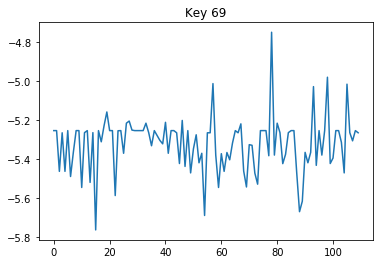

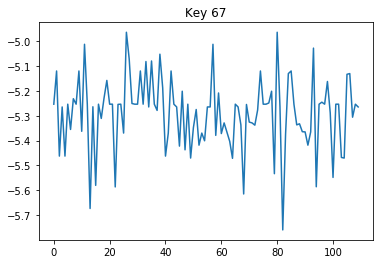

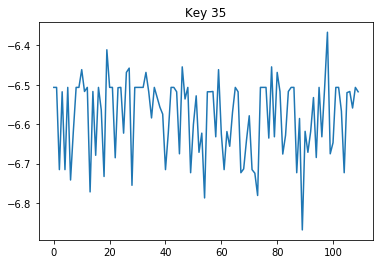

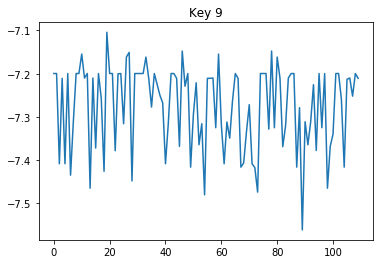

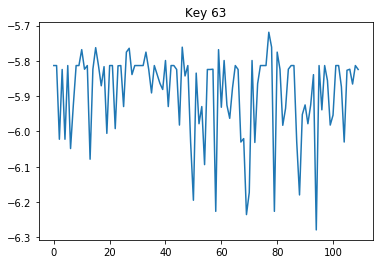

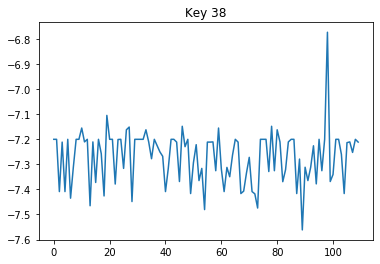

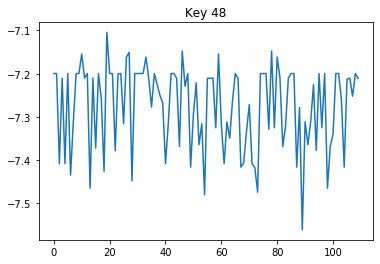

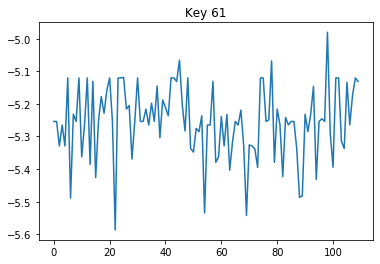

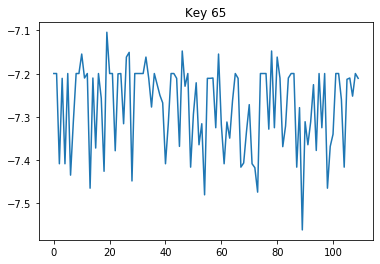

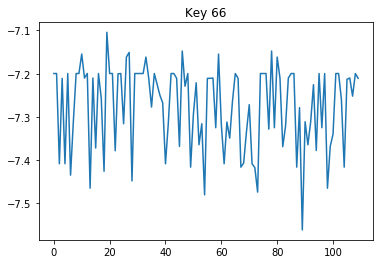

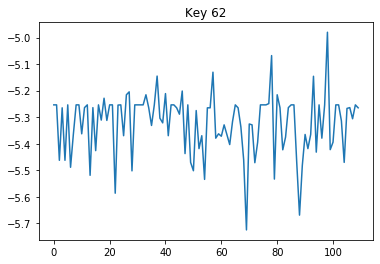

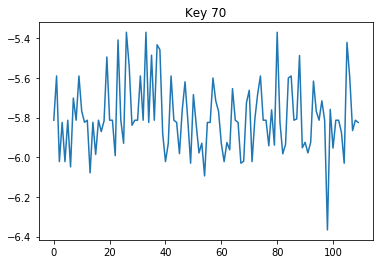

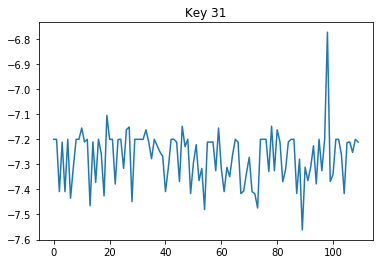

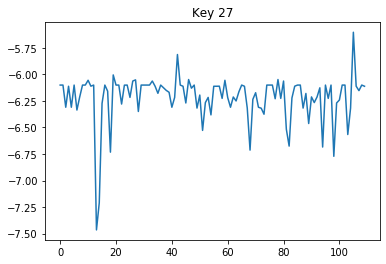

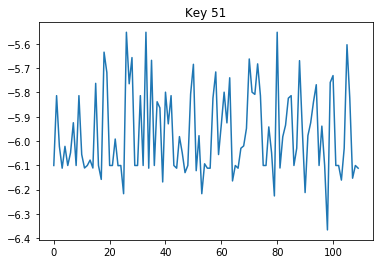

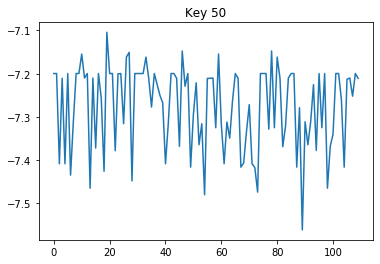

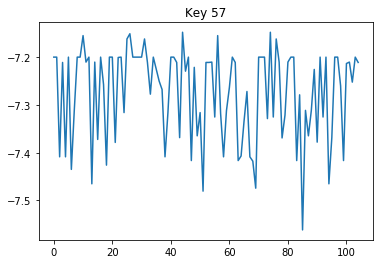

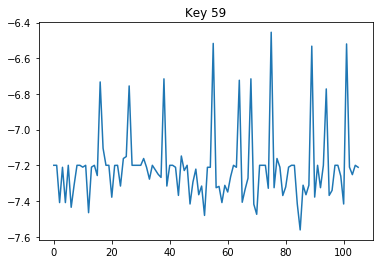

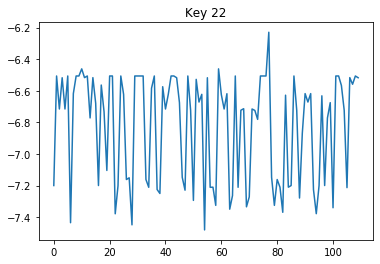

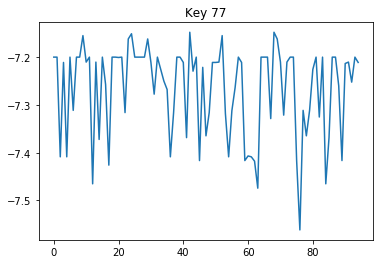

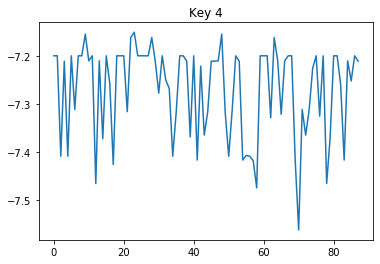

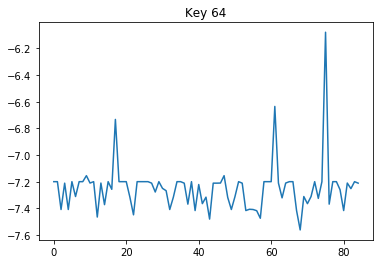

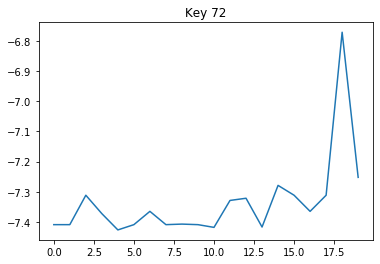

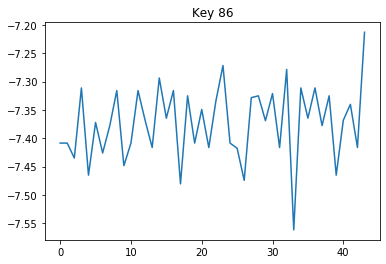

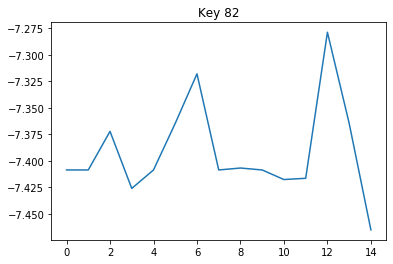

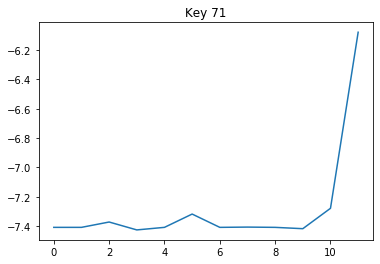

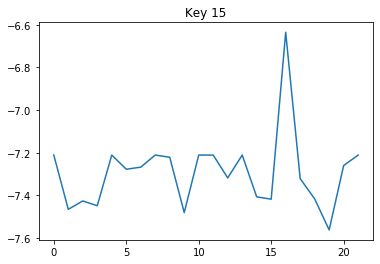

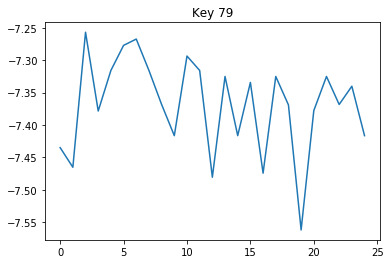

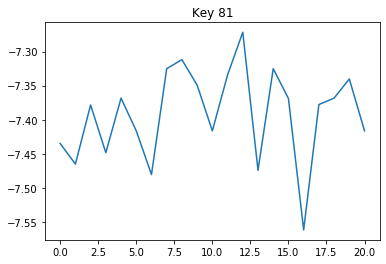

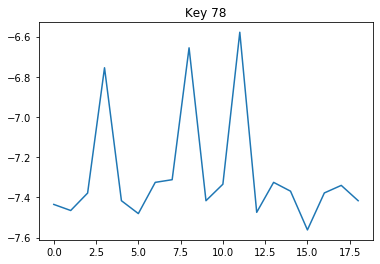

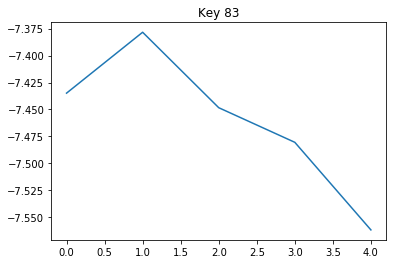

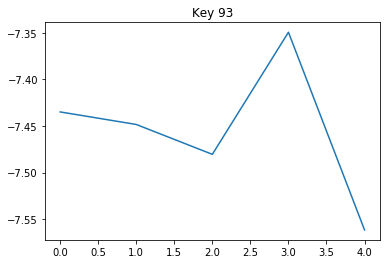

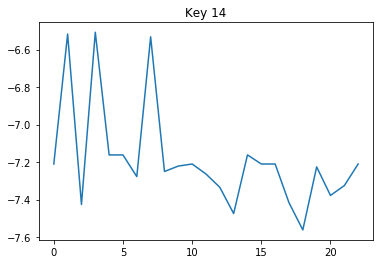

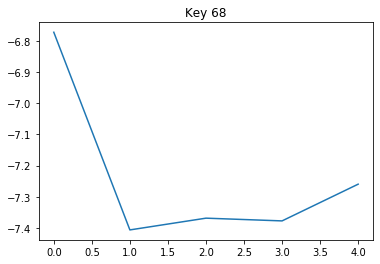

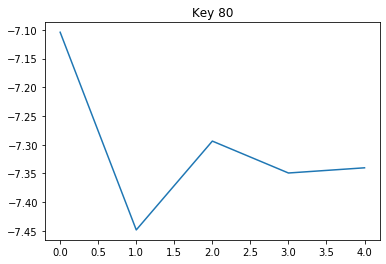

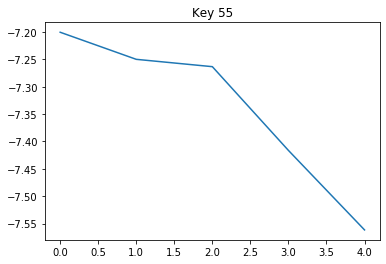

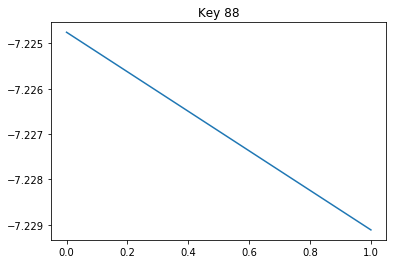

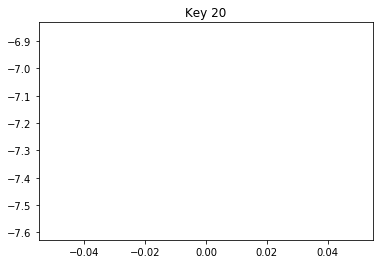

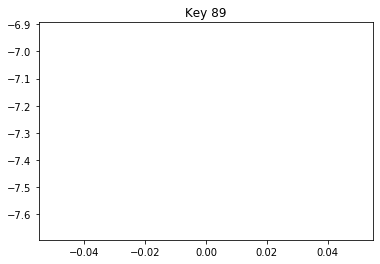

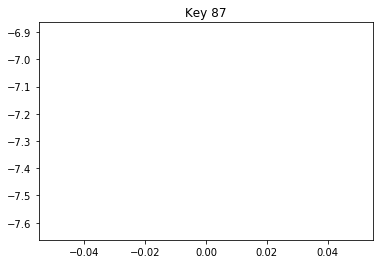

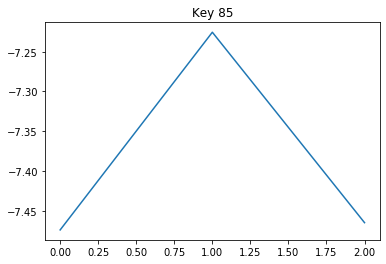

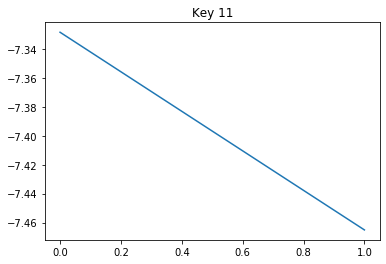

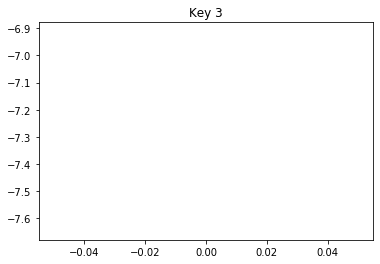

In [133]:
def print_stats(tfdict):
    keys = list(tfdict.keys())
    for i in range(0, len(keys)):
        plt.plot(tfdict[keys[i]])
        plt.title(f"Key {keys[i]}")
        plt.show()

print_stats(tfdict)

In [139]:
import re

def normalize(source_code):
    res = re.sub("import.*;", "", source_code)
    res = re.sub("\".+\"", "\"\"", res)
    res = re.sub("\t+", "", res)
    res = re.sub("\n", "", res)
    res = re.sub("\s+", " ", res)
    res = re.sub("({|})", " ", res)
    res = re.sub("\d+", "t0", res)
    res = re.sub("(for|while)", "loop", res)
    return res

def normalize_for_ai(source_code):
    res = re.sub("\/\*.*\*\/", "", source_code, flags=re.DOTALL) # multiline comment
    res = re.sub("\/\/.*", "", res) # inline comments
    res = re.sub("\".+\"", "\"\"", res) # string values
    res = re.sub("\d+", "$", res)
    return res

def normalize_for_ast(source_code):
    res = re.sub("import.*;", "", source_code)
    res = re.sub("package.*;", "", res)
    return res


In [144]:
import pandas as pd
import glob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

df = pd.DataFrame(columns=["source_code", "token_stream", "normalized"])

def parse_to_compositional_tokens(code):
    #print("parsing: ", self.ID)
    code_stream = antlr4.InputStream(code)
    lexer = JavaLexer(code_stream)
    token_stream = antlr4.CommonTokenStream(lexer)
    parser = JavaParser(token_stream)
    tree = parser.compilationUnit()

    printer = KeyPrinter()
    walker = antlr4.ParseTreeWalker()
    walker.walk(printer, tree)

    return printer.get_result()

def parse_data(codeDict):
    ids = list(codeDict.keys())
    token_list = [None] * len(ids)
    normalized_list = [None] * len(ids)
    for i in range(0, len(ids)):
        c = codeDict[ids[i]]
        token_list[i] = parse_to_compositional_tokens(c)
        normalized_list[i] = normalize_for_ai(c)
    return token_list, normalized_list
   

tlist, nlist = parse_data(rain)

In [146]:
df = pd.DataFrame({ "token_stream": tlist, "normalized": nlist })

In [148]:
ngram_vectorizer = CountVectorizer(analyzer='word', 
                                   ngram_range=(5, 5),
                                   token_pattern="[\S]+",
                                   lowercase= False,
                                   strip_accents="ascii")

#transformer = TfidfTransformer(smooth_idf=True, norm=None)
transformer = TfidfTransformer(smooth_idf=False)

X = ngram_vectorizer.fit_transform(df.token_stream)
tfidf = transformer.fit_transform(X)

res_tf = pd.DataFrame(X.A, columns=ngram_vectorizer.get_feature_names())

res_idf = pd.DataFrame(tfidf.A, columns=ngram_vectorizer.get_feature_names())

[t-SNE] Computing 109 nearest neighbors...
[t-SNE] Indexed 110 samples in 0.000s...
[t-SNE] Computed neighbors for 110 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 110 / 110
[t-SNE] Mean sigma: 3.606860
[t-SNE] Computed conditional probabilities in 0.008s
[t-SNE] Iteration 50: error = 54.2180023, gradient norm = 0.5736421 (50 iterations in 0.061s)
[t-SNE] Iteration 100: error = 53.0211182, gradient norm = 0.5251226 (50 iterations in 0.044s)
[t-SNE] Iteration 150: error = 51.3255463, gradient norm = 0.5589690 (50 iterations in 0.032s)
[t-SNE] Iteration 200: error = 57.9921684, gradient norm = 0.4797617 (50 iterations in 0.030s)
[t-SNE] Iteration 250: error = 55.3582344, gradient norm = 0.5664566 (50 iterations in 0.034s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.358234
[t-SNE] Iteration 300: error = 0.7768545, gradient norm = 0.0081987 (50 iterations in 0.050s)
[t-SNE] Iteration 350: error = 0.3980343, gradient norm = 0.0136739 

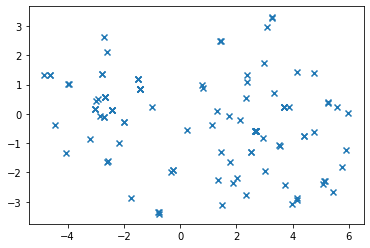

In [156]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn import manifold

from mpl_toolkits.mplot3d import Axes3D

# TODO: Add treshold

sim_matrix = np.around(cosine_similarity(tfidf), decimals=8)
dist_matrix = np.subtract(np.ones(sim_matrix.shape,  dtype=np.int8), sim_matrix) # sim <=> 1 - dist

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(tfidf)
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)
#%%
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], marker="x")

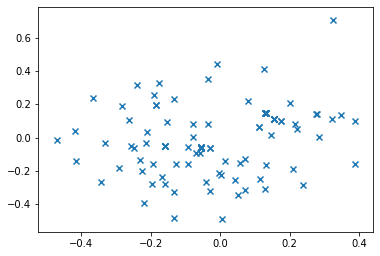

In [158]:
mds = manifold.MDS(n_components=2, dissimilarity="precomputed")
results = mds.fit(dist_matrix)

coords = results.embedding_

plt.subplots_adjust(bottom = 0.1)
plt.scatter(coords[:, 0], coords[:, 1], marker = 'x')

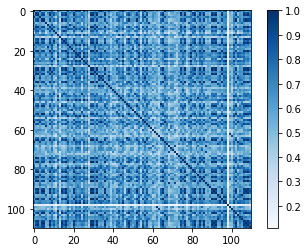

In [160]:
plt.imshow(sim_matrix, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

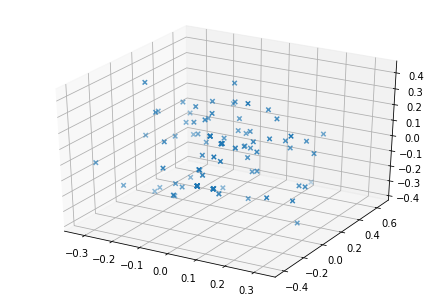

In [161]:
mds = manifold.MDS(n_components=3, dissimilarity="precomputed")
results = mds.fit(dist_matrix)

coords = results.embedding_

fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2], marker="x")

In [162]:
from sklearn.cluster import DBSCAN

db = DBSCAN(min_samples=2, metric="precomputed", eps=0.05).fit(dist_matrix)
labels = db.labels_ # -1 = noise
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
unique_labels = set(labels) 

labels

array([ 0,  1,  2, -1,  3,  3, -1, -1,  2,  4,  5, -1,  6, -1,  3,  5,  2,
        7, -1, -1,  2,  7,  8,  7,  9,  7, -1,  4, -1,  2,  2,  4,  2, 10,
        0, -1,  2, -1, 10, -1, -1, -1,  9, -1, 11,  7, -1, 12,  3, -1, -1,
       -1,  3,  7, -1, -1,  0, -1, -1, -1, -1, -1, 13, -1, 12,  2,  0, -1,
       14, -1, -1, -1, -1, -1,  1, -1,  2, -1, -1,  7, -1,  2,  8, 11,  2,
       -1,  2, 14, -1, -1,  2,  3,  2, 15, 16,  2, 16,  7, -1, 13, -1,  6,
        3,  0, -1, 15,  2,  3,  2, -1])

In [163]:
clusters = {}

for i, c in enumerate(labels):
    if c == -1: continue
    if not c in clusters.keys():
        clusters[c] = [i]
    else:
        clusters[c].append(i)

clusters

{0: [0, 34, 56, 66, 103],
 1: [1, 74],
 2: [2, 8, 16, 20, 29, 30, 32, 36, 65, 76, 81, 84, 86, 90, 92, 95, 106, 108],
 3: [4, 5, 14, 48, 52, 91, 102, 107],
 4: [9, 27, 31],
 5: [10, 15],
 6: [12, 101],
 7: [17, 21, 23, 25, 45, 53, 79, 97],
 8: [22, 82],
 9: [24, 42],
 10: [33, 38],
 11: [44, 83],
 12: [47, 64],
 13: [62, 99],
 14: [68, 87],
 15: [93, 105],
 16: [94, 96]}

In [169]:
def print_cluster_code(codeDict, indexes):
    keys = list(codeDict.keys())
    for i in indexes:
        print(codeDict[keys[i]])

print_cluster_code(rain, clusters[6])


import java.util.Scanner;

public class MarsinLampotilanKeskiarvo {

    public static void main(String[] args) {
        Scanner lukija = new Scanner(System.in);
        int summa = 0;
        int kelvollisiaLukuja = 0;

        while (true) {
            System.out.print("Syötä mittaus: ");
            int mittaus = Integer.parseInt(lukija.nextLine());

            if (mittaus == 9999) {
                break;
            }
            if (mittaus <= 20 && mittaus >= -140) {
                summa += mittaus;
                kelvollisiaLukuja++;
            }
        }
        double keskiarvo = (double) summa / kelvollisiaLukuja;
        System.out.println("Mittausten keskiarvo: " + keskiarvo);
    }
}


import java.util.Scanner;

public class MarsinLampotilanKeskiarvo {

    public static void main(String[] args) {
        Scanner lukija = new Scanner(System.in);
        int summa = 0;
        int n = 0;
        
        while(true) {
            System.out.print("Syötä mittaus:");

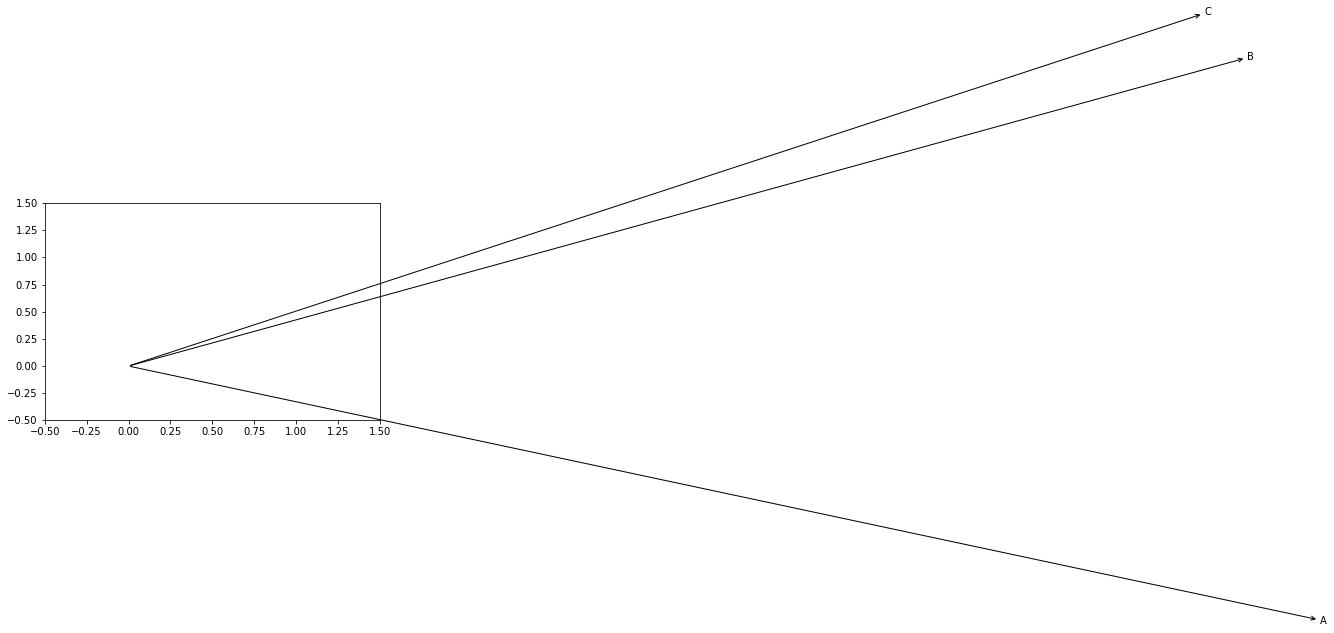

In [153]:
from sklearn.manifold import TSNE
import matplotlib.pylab as plt
from sklearn.decomposition import TruncatedSVD

from tikzplotlib import save as tikz_save

X_reduced = TruncatedSVD(n_components=2, random_state=0).fit_transform(tfidf.todense())

plt.xlim(-0.5, 1.5)
plt.ylim(-0.5, 1.5)

example_code_classes = ["A", "B", "C"]

for i in range(0, 3):
    plt.annotate(example_code_classes[i],
            xy=(0, 0), xycoords='data',
            xytext=(X_reduced[i, 0], X_reduced[i, 1]), textcoords='data',
            arrowprops=dict(arrowstyle="<-",
                            connectionstyle="arc3"),
            )
            


In [36]:
import difflib

vals = list(rain.values())

for line in difflib.unified_diff(vals[0].split('\n'), vals[1].split('\n')):
    print(line)

--- 

+++ 

@@ -5,24 +5,25 @@

 
     public static void main(String[] args) {
         Scanner lukija = new Scanner(System.in);
+        int mittaus = 0;
+        int lukumaara = 0;
+        int summa = 0;
         
-        int summa = 0;
-        int syotteet = 0;
+        while(true) {
+            System.out.print("Syötä mittaus: "); 
+            mittaus = Integer.parseInt(lukija.nextLine());
+            
+            if(mittaus == 9999) {
+                break;
+            }
+            if(mittaus < -140 || mittaus > 20) {
+                continue;
+            }
+            summa += mittaus;
+            lukumaara++;
+        }
+        System.out.println("Mittausten keskiarvo: " + (1.0 * summa / lukumaara));
         
-        while (true) {
-            System.out.print("Syötä luku: ");
-            int syote = Integer.parseInt(lukija.nextLine());
-            
-            if (syote == 9999) {
-                break;
-            } else if (syote <= 20 && syote >= -140